In [6]:
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 18.7 MB/s eta 0:00:0000:0100:01


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [7]:

transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize to zero mean and unit variance.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)




batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))


Using downloaded and verified file: ./data/train_32x32.mat


100%|██████████| 64.3M/64.3M [00:31<00:00, 2.07MB/s]


Number of training samples: 73257
Number of test samples: 26032


In [8]:
class ConvAutoencoder(nn.Module):
    def __init__(self, activation_fn=nn.ReLU):
        super(ConvAutoencoder, self).__init__()
        # Saving the activation function to be used.(For tuning purposes.)
        self.act = activation_fn(inplace=True) if 'inplace' in activation_fn.__init__.__code__.co_varnames else activation_fn()

        # Encoder: input shape (3, 32, 32)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # -> (32, 16, 16)
            self.act,
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (64, 8, 8)
            self.act,
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # -> (128, 4, 4)
            self.act
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, output_padding=1, padding=1),  # -> (64, 8, 8)
            self.act,
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, output_padding=1, padding=1),   # -> (32, 16, 16)
            self.act,
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, output_padding=1, padding=1),    # -> (3, 32, 32)
            nn.Tanh()  # Since our inputs are normalized to [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [9]:
def clip_weights(model, clip_value=0.5):
    with torch.no_grad():
        for param in model.parameters():
            param.clamp_(-clip_value, clip_value)



def psnr(mse_loss, max_pixel=1.0):
    # max_pixel is 1.0 when inputs are normalized between -1 and 1 or 0 and 1.
    # Here, since our autoencoder output uses Tanh and input is normalized to [-1, 1],
    # the dynamic range is 2.
    return 10 * torch.log10((max_pixel ** 2) / mse_loss)


In [10]:
def train_autoencoder(model, train_loader, test_loader, optimizer, num_epochs=100,
                      device='cuda' if torch.cuda.is_available() else 'cpu',
                      l1_lambda=0.0, clip_value=0.5,
                      early_stopping_patience=10, min_delta=1e-4):
    model = model.to(device)
    mse_loss_fn = nn.MSELoss()
    train_losses = []
    test_psnr_values = []

    best_loss = float('inf')
    epochs_no_improve = 0
    start_time = time.time()

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = mse_loss_fn(outputs, data)

            # L1 sparsity is used only if l1_lambda > 0.
            if l1_lambda > 0:
                l1_loss = 0.0
                for param in model.parameters():
                    l1_loss += torch.sum(torch.abs(param))
                loss += l1_lambda * l1_loss

            loss.backward()
            optimizer.step()

            # Weight clipping
            clip_weights(model, clip_value)

            running_loss += loss.item() * data.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        # Evaluating on test set using PSNR.
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                outputs = model(data)
                loss_val = mse_loss_fn(outputs, data)
                test_loss += loss_val.item() * data.size(0)
        avg_test_loss = test_loss / len(test_loader.dataset)
        # Use max_pixel=2.0 since input range is [-1, 1]
        current_psnr = psnr(torch.tensor(avg_test_loss), max_pixel=2.0).item()
        test_psnr_values.append(current_psnr)

        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {avg_loss:.6f}, Test MSE: {avg_test_loss:.6f}, PSNR: {current_psnr:.2f} dB")

        # Early stopping: if the improvement in training loss is too small.
        if best_loss - avg_loss > min_delta:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    total_time = time.time() - start_time
    print(f"Training completed in {total_time/60:.2f} minutes.")
    return train_losses, test_psnr_values



--- Tuning Experiment: Activation = ReLU, Optimizer = Adam ---
Epoch [1/20], Train Loss: 0.016020, Test MSE: 0.002991, PSNR: 31.26 dB
Epoch [2/20], Train Loss: 0.002660, Test MSE: 0.001852, PSNR: 33.34 dB
Epoch [3/20], Train Loss: 0.001885, Test MSE: 0.001675, PSNR: 33.78 dB
Epoch [4/20], Train Loss: 0.001517, Test MSE: 0.001157, PSNR: 35.39 dB
Epoch [5/20], Train Loss: 0.001269, Test MSE: 0.000894, PSNR: 36.51 dB
Epoch [6/20], Train Loss: 0.001091, Test MSE: 0.000897, PSNR: 36.49 dB
Epoch [7/20], Train Loss: 0.001006, Test MSE: 0.000725, PSNR: 37.42 dB
Epoch [8/20], Train Loss: 0.000908, Test MSE: 0.000847, PSNR: 36.74 dB
Epoch [9/20], Train Loss: 0.000834, Test MSE: 0.000634, PSNR: 38.00 dB
Epoch [10/20], Train Loss: 0.000795, Test MSE: 0.000605, PSNR: 38.20 dB
Epoch [11/20], Train Loss: 0.000740, Test MSE: 0.000609, PSNR: 38.18 dB
Epoch [12/20], Train Loss: 0.000715, Test MSE: 0.000562, PSNR: 38.52 dB
Epoch [13/20], Train Loss: 0.000666, Test MSE: 0.000498, PSNR: 39.05 dB
Epoch [14

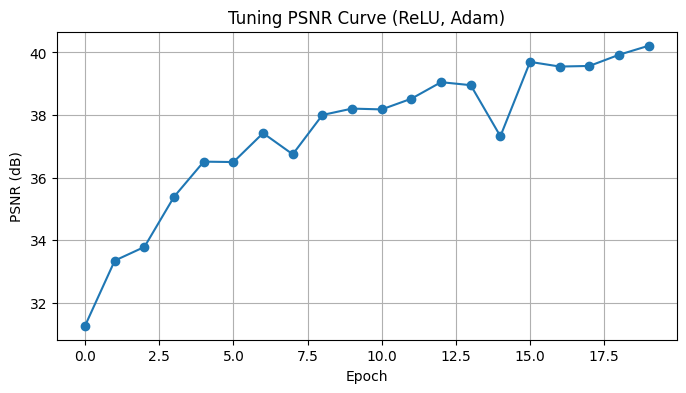


--- Tuning Experiment: Activation = ReLU, Optimizer = SGD ---
Epoch [1/20], Train Loss: 0.171242, Test MSE: 0.210794, PSNR: 12.78 dB
Epoch [2/20], Train Loss: 0.163735, Test MSE: 0.206180, PSNR: 12.88 dB
Epoch [3/20], Train Loss: 0.160517, Test MSE: 0.204236, PSNR: 12.92 dB
Epoch [4/20], Train Loss: 0.159137, Test MSE: 0.203412, PSNR: 12.94 dB
Epoch [5/20], Train Loss: 0.158538, Test MSE: 0.203061, PSNR: 12.94 dB
Epoch [6/20], Train Loss: 0.158275, Test MSE: 0.202908, PSNR: 12.95 dB
Epoch [7/20], Train Loss: 0.158155, Test MSE: 0.202840, PSNR: 12.95 dB
Epoch [8/20], Train Loss: 0.158094, Test MSE: 0.202804, PSNR: 12.95 dB
Epoch [9/20], Train Loss: 0.158057, Test MSE: 0.202777, PSNR: 12.95 dB
Epoch [10/20], Train Loss: 0.158033, Test MSE: 0.202759, PSNR: 12.95 dB
Epoch [11/20], Train Loss: 0.158017, Test MSE: 0.202746, PSNR: 12.95 dB
Epoch [12/20], Train Loss: 0.158005, Test MSE: 0.202736, PSNR: 12.95 dB
Epoch [13/20], Train Loss: 0.157994, Test MSE: 0.202725, PSNR: 12.95 dB
Epoch [14/

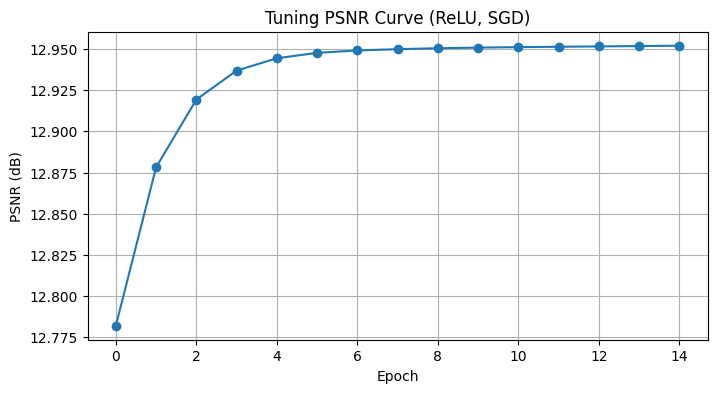


--- Tuning Experiment: Activation = LeakyReLU, Optimizer = Adam ---
Epoch [1/20], Train Loss: 0.014010, Test MSE: 0.003241, PSNR: 30.91 dB
Epoch [2/20], Train Loss: 0.002538, Test MSE: 0.001543, PSNR: 34.14 dB
Epoch [3/20], Train Loss: 0.001641, Test MSE: 0.001212, PSNR: 35.19 dB
Epoch [4/20], Train Loss: 0.001334, Test MSE: 0.001003, PSNR: 36.01 dB
Epoch [5/20], Train Loss: 0.001156, Test MSE: 0.000836, PSNR: 36.80 dB
Epoch [6/20], Train Loss: 0.000995, Test MSE: 0.000706, PSNR: 37.53 dB
Epoch [7/20], Train Loss: 0.000914, Test MSE: 0.000628, PSNR: 38.04 dB
Epoch [8/20], Train Loss: 0.000869, Test MSE: 0.000920, PSNR: 36.38 dB
Epoch [9/20], Train Loss: 0.000744, Test MSE: 0.000755, PSNR: 37.24 dB
Epoch [10/20], Train Loss: 0.000718, Test MSE: 0.000516, PSNR: 38.89 dB
Epoch [11/20], Train Loss: 0.000697, Test MSE: 0.000578, PSNR: 38.40 dB
Epoch [12/20], Train Loss: 0.000627, Test MSE: 0.000456, PSNR: 39.43 dB
Epoch [13/20], Train Loss: 0.000607, Test MSE: 0.000447, PSNR: 39.52 dB
Epoc

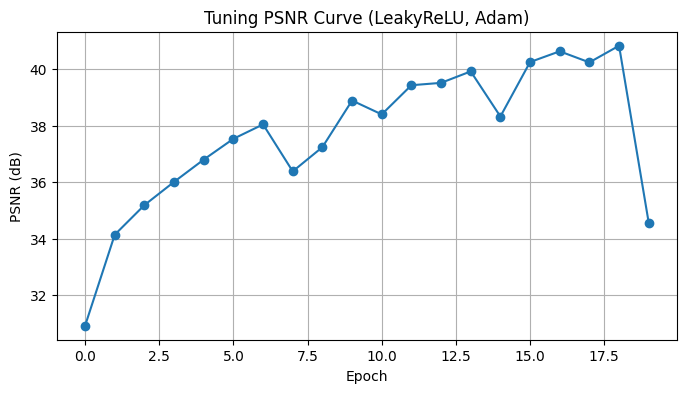


--- Tuning Experiment: Activation = LeakyReLU, Optimizer = SGD ---
Epoch [1/20], Train Loss: 0.171793, Test MSE: 0.208408, PSNR: 12.83 dB
Epoch [2/20], Train Loss: 0.164125, Test MSE: 0.204549, PSNR: 12.91 dB
Epoch [3/20], Train Loss: 0.160731, Test MSE: 0.203106, PSNR: 12.94 dB
Epoch [4/20], Train Loss: 0.159244, Test MSE: 0.202632, PSNR: 12.95 dB
Epoch [5/20], Train Loss: 0.158591, Test MSE: 0.202526, PSNR: 12.96 dB
Epoch [6/20], Train Loss: 0.158299, Test MSE: 0.202543, PSNR: 12.96 dB
Epoch [7/20], Train Loss: 0.158165, Test MSE: 0.202589, PSNR: 12.95 dB
Epoch [8/20], Train Loss: 0.158099, Test MSE: 0.202634, PSNR: 12.95 dB
Epoch [9/20], Train Loss: 0.158064, Test MSE: 0.202668, PSNR: 12.95 dB
Epoch [10/20], Train Loss: 0.158043, Test MSE: 0.202691, PSNR: 12.95 dB
Epoch [11/20], Train Loss: 0.158029, Test MSE: 0.202706, PSNR: 12.95 dB
Epoch [12/20], Train Loss: 0.158018, Test MSE: 0.202713, PSNR: 12.95 dB
Epoch [13/20], Train Loss: 0.158009, Test MSE: 0.202717, PSNR: 12.95 dB
Epoch

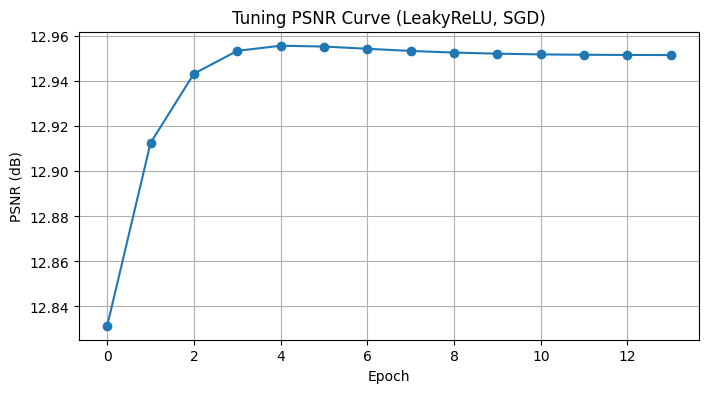

In [11]:
# Defining hyperparameters for tuning
tune_epochs = 20
learning_rate = 1e-3
clip_value = 0.5

# Try two activation functions and two optimizers.
activation_functions = {
    'ReLU': nn.ReLU,
    'LeakyReLU': nn.LeakyReLU  # default negative_slope=0.01
}

optimizers_dict = {
    'Adam': optim.Adam,
    'SGD': optim.SGD
}

# Store tuning results
tuning_results = {}

for act_name, act_fn in activation_functions.items():
    for opt_name, opt_fn in optimizers_dict.items():
        print(f"\n--- Tuning Experiment: Activation = {act_name}, Optimizer = {opt_name} ---")
        model = ConvAutoencoder(activation_fn=act_fn)
        optimizer = opt_fn(model.parameters(), lr=learning_rate)
        train_losses, test_psnr = train_autoencoder(
            model, train_loader, test_loader,
            optimizer, num_epochs=tune_epochs, l1_lambda=0.0, clip_value=clip_value,
            early_stopping_patience=5
        )
        tuning_results[(act_name, opt_name)] = {
            'train_losses': train_losses,
            'test_psnr': test_psnr,
            'final_psnr': test_psnr[-1]
        }
        plt.figure(figsize=(8,4))
        plt.plot(test_psnr, marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("PSNR (dB)")
        plt.title(f"Tuning PSNR Curve ({act_name}, {opt_name})")
        plt.grid(True)
        plt.show()


In [12]:
for key, result in tuning_results.items():
    act_name, opt_name = key
    print(f"Activation: {act_name}, Optimizer: {opt_name}, Final PSNR: {result['final_psnr']:.2f} dB")


Activation: ReLU, Optimizer: Adam, Final PSNR: 40.21 dB
Activation: ReLU, Optimizer: SGD, Final PSNR: 12.95 dB
Activation: LeakyReLU, Optimizer: Adam, Final PSNR: 34.56 dB
Activation: LeakyReLU, Optimizer: SGD, Final PSNR: 12.95 dB



=== Final Training: Baseline Autoencoder (MSE + Weight Clipping) ===
Epoch [1/100], Train Loss: 0.014670, Test MSE: 0.002889, PSNR: 31.41 dB
Epoch [2/100], Train Loss: 0.002634, Test MSE: 0.001993, PSNR: 33.02 dB
Epoch [3/100], Train Loss: 0.001784, Test MSE: 0.001220, PSNR: 35.16 dB
Epoch [4/100], Train Loss: 0.001432, Test MSE: 0.001044, PSNR: 35.83 dB
Epoch [5/100], Train Loss: 0.001200, Test MSE: 0.001235, PSNR: 35.10 dB
Epoch [6/100], Train Loss: 0.001064, Test MSE: 0.000791, PSNR: 37.04 dB
Epoch [7/100], Train Loss: 0.000988, Test MSE: 0.000669, PSNR: 37.77 dB
Epoch [8/100], Train Loss: 0.000863, Test MSE: 0.000627, PSNR: 38.05 dB
Epoch [9/100], Train Loss: 0.000814, Test MSE: 0.000579, PSNR: 38.39 dB
Epoch [10/100], Train Loss: 0.000770, Test MSE: 0.000521, PSNR: 38.85 dB
Epoch [11/100], Train Loss: 0.000709, Test MSE: 0.000492, PSNR: 39.10 dB
Epoch [12/100], Train Loss: 0.000674, Test MSE: 0.000743, PSNR: 37.31 dB
Epoch [13/100], Train Loss: 0.000632, Test MSE: 0.000504, PSNR:

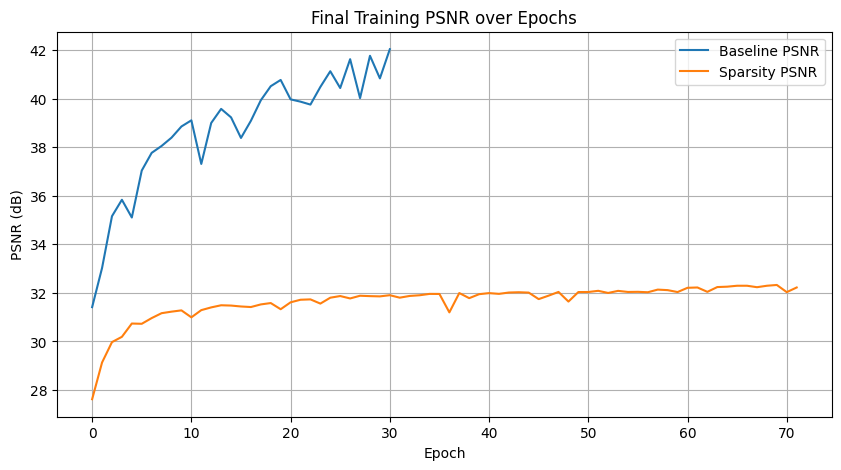

In [13]:
# Best hyperparameters from tuning (adjusted based on the previous results.)
best_activation = nn.ReLU      # or nn.LeakyReLU
best_optimizer_fn = optim.Adam # or optim.SGD

num_epochs = 100
l1_lambda = 1e-5  
early_stopping_patience = 10  

# Training the baseline autoencoder (without L1 sparsity)
print("\n=== Final Training: Baseline Autoencoder (MSE + Weight Clipping) ===")
model_baseline = ConvAutoencoder(activation_fn=best_activation)
optimizer_baseline = best_optimizer_fn(model_baseline.parameters(), lr=learning_rate)
baseline_train_losses, baseline_test_psnr = train_autoencoder(
    model_baseline, train_loader, test_loader,
    optimizer_baseline, num_epochs=num_epochs, l1_lambda=0.0, clip_value=clip_value,
    early_stopping_patience=early_stopping_patience
)

# Training the sparsity autoencoder (with L1 penalty)
print("\n=== Final Training: Sparsity Autoencoder (MSE + Weight Clipping + L1 penalty) ===")
model_sparsity = ConvAutoencoder(activation_fn=best_activation)
optimizer_sparsity = best_optimizer_fn(model_sparsity.parameters(), lr=learning_rate)
sparsity_train_losses, sparsity_test_psnr = train_autoencoder(
    model_sparsity, train_loader, test_loader,
    optimizer_sparsity, num_epochs=num_epochs, l1_lambda=l1_lambda, clip_value=clip_value,
    early_stopping_patience=early_stopping_patience
)

# Plotting final PSNR curves for both models.
plt.figure(figsize=(10,5))
plt.plot(baseline_test_psnr, label='Baseline PSNR')
plt.plot(sparsity_test_psnr, label='Sparsity PSNR')
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("Final Training PSNR over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
print("Final PSNR Comparison:")
print(f"Baseline Autoencoder Final PSNR: {baseline_test_psnr[-1]:.2f} dB")
print(f"Sparsity Autoencoder Final PSNR: {sparsity_test_psnr[-1]:.2f} dB")


Final PSNR Comparison:
Baseline Autoencoder Final PSNR: 42.03 dB
Sparsity Autoencoder Final PSNR: 32.22 dB


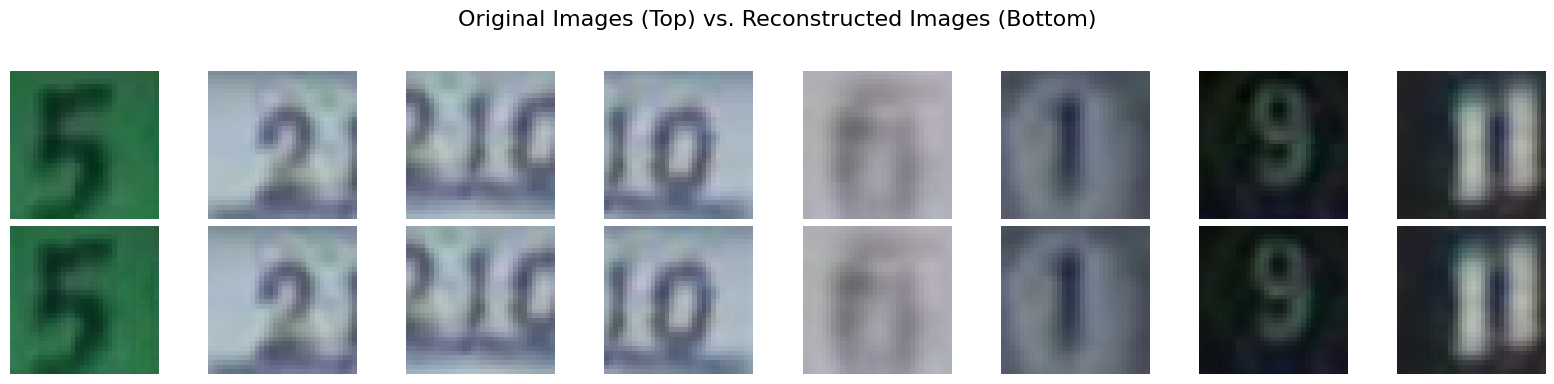

In [15]:
import torchvision.utils as vutils

# Device should be same as before.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def imshow(img, ax):
    """
    Unnormalize and plot a single image.
    """
    # Unnormalize image: original normalization was mean=0.5, std=0.5.
    img = img * 0.5 + 0.5  
    npimg = img.cpu().numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    ax.imshow(npimg)
    ax.axis('off')

# Get a batch of test images
dataiter = iter(test_loader)
images, _ = next(dataiter)  # use the built-in next() function
images = images.to(device)

# Use the baseline autoencoder to get reconstructed images.
model_baseline.eval()  # ensure the model is in eval mode
with torch.no_grad():
    reconstructed = model_baseline(images)

# Set number of images to display
num_images = 8

# Create subplots: one row for original images and one for reconstructed images
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
fig.suptitle("Original Images (Top) vs. Reconstructed Images (Bottom)", fontsize=16)

for i in range(num_images):
    # Plot original image
    imshow(images[i], axes[0, i])
    
    # Plot reconstructed image
    imshow(reconstructed[i], axes[1, i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
